In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


58889256/58889256 [==============================] - 3s 0us/step
Training on Fold: 1
Found 4373 validated image filenames.
Found 626 validated image filenames.
Epoch 1/20
137/137 [==============================] - 4153s 30s/step - loss: 0.3093 - precision: 0.5058 - recall: 0.1741 - f1_score: 0.2528 - accuracy: 0.3325 - val_loss: 0.2654 - val_precision: 0.6515 - val_recall: 0.2165 - val_f1_score: 0.3240 - val_accuracy: 0.3546 - lr: 5.0000e-05
Epoch 2/20
137/137 [==============================] - 68s 496ms/step - loss: 0.2708 - precision: 0.6241 - recall: 0.2691 - f1_score: 0.3741 - accuracy: 0.3673 - val_loss: 0.2696 - val_precision: 0.6270 - val_recall: 0.2014 - val_f1_score: 0.3060 - val_accuracy: 0.3371 - lr: 5.0000e-05
Epoch 3/20
137/137 [==============================] - 68s 496ms/step - loss: 0.2492 - precision: 0.6661 - recall: 0.3375 - f1_score: 0.4460 - accuracy: 0.4089 - val_loss: 0.2651 - val_precision: 0.6193 - val_recall: 0.3162 - val_f1_score: 0.4189 - val_accuracy: 0.3850

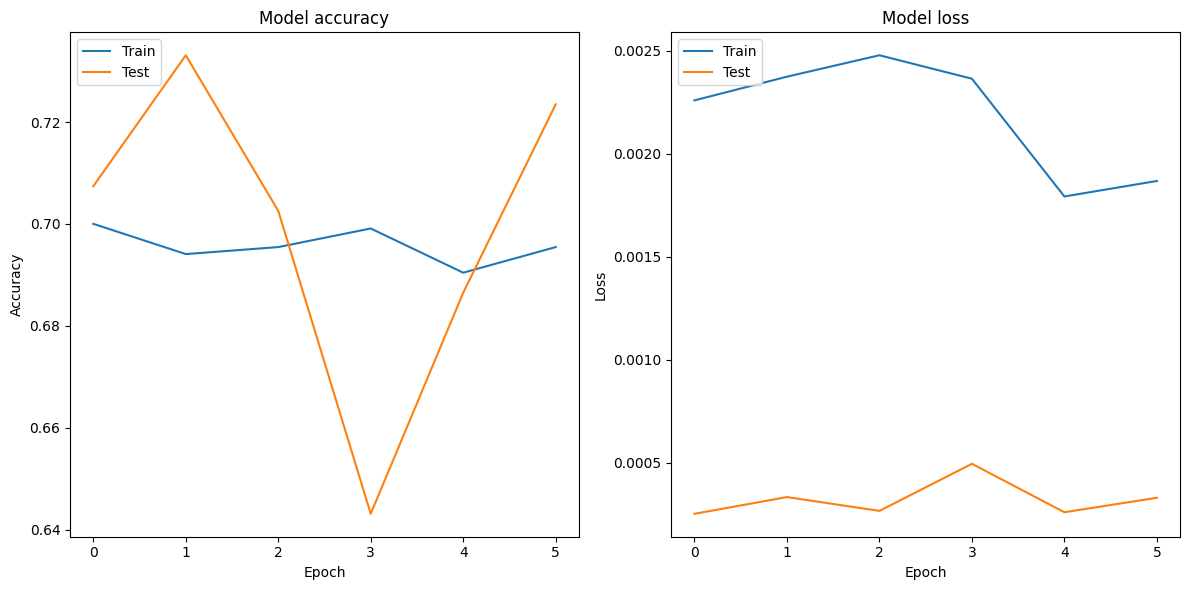

In [ ]:
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skmultilearn.model_selection import IterativeStratification
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.applications import VGG16
from keras.models import Model
# Define F1-score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def create_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

    for layer in base_model.layers[:-5]:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(len(target_columns), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=[Precision(), Recall(), f1_score, 'accuracy'])

    return model

data = pd.read_csv('/content/drive/MyDrive/cleaned_fileforread5000.csv')
labels = data[[ "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"]].to_numpy()
target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"
]
data[target_columns] = data[target_columns].fillna(0)
data[target_columns] = data[target_columns].applymap(lambda x: 0 if x < 0 else x)
n_folds = 8
stratified_kf = IterativeStratification(n_splits=n_folds, order=1)

datagen = ImageDataGenerator(rescale=1./255.)

all_histories = []

best_val_loss = float('inf')


model = create_model()

for i, (train, test) in enumerate(stratified_kf.split(data, labels)):
    print(f"Training on Fold: {i+1}")

    train_data = data.iloc[train]
    test_data = data.iloc[test]

    train_generator = datagen.flow_from_dataframe(train_data, x_col="drive_path", y_col=target_columns,
                                                  target_size=(299, 299), class_mode='raw', batch_size=32)
    test_generator = datagen.flow_from_dataframe(test_data, x_col="drive_path", y_col=target_columns,
                                                 target_size=(299, 299), class_mode='raw', batch_size=32)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, reduce_lr])

    all_histories.append(history.history)

    current_val_loss = min(history.history['val_loss'])
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        save_model(model, "/content/drive/MyDrive/best_model5000.h5")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(all_histories[-1]['accuracy'])
plt.plot(all_histories[-1]['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(all_histories[-1]['loss'])
plt.plot(all_histories[-1]['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


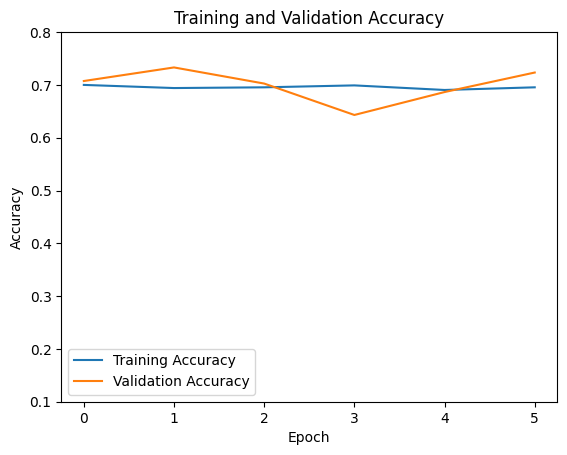

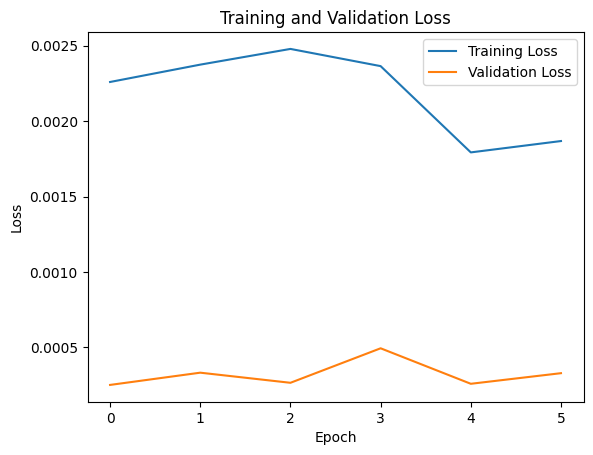

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([i / 10 for i in range(1, 10)])
plt.ylim(0.1, 0.8)
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


loaded_model = load_model("/content/drive/MyDrive/best_model5000.h5", custom_objects={'f1_score': f1_score})


img_path = "/content/drive/MyDrive/p11_images/p11009622/s58000523/3901e8bd-e18a4fcb-aa198649-114fc246-fe419e35.jpg"
img = image.load_img(img_path, target_size=(299, 299))


img_array = image.img_to_array(img) / 255.0


img_array = np.expand_dims(img_array, axis=0)


prediction = loaded_model.predict(img_array)

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"
]
threshold = 0.5

# Initialize a list to hold the names of the predicted diseases
predicted_diseases = []

# Check which diseases have a predicted probability above the threshold
for i, prob in enumerate(prediction[0]):
    print(prob, "--")
    if prob > threshold:
        predicted_diseases.append(disease_names[i])

# Output the names of the predicted diseases
if predicted_diseases:
    print("Predicted diseases:", ", ".join(predicted_diseases))
else:
    print("No diseases predicted above the threshold.")


1/1 [==============================] - 1s 823ms/step
0.0049285893 --
0.00018960511 --
2.234228e-08 --
0.0004050995 --
3.7421844e-07 --
2.5867598e-06 --
9.0417285e-05 --
1.2872788e-06 --
0.059566986 --
0.22287826 --
1.921299e-08 --
9.787502e-07 --
7.140791e-06 --
0.00017542463 --
No diseases predicted above the threshold.


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from keras import backend as K

loaded_model = load_model("/content/drive/MyDrive/best_model5000.h5", custom_objects={'f1_score': f1_score})

csv_path = '/content/drive/MyDrive/p11_report.csv'
data = pd.read_csv(csv_path)

target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"
]

true_label_count = 0
correct_predictions = 0

# List to store paths of incorrectly predicted images
incorrectly_predicted_paths = []

# Loop through the first 10 rows in the CSV
for index, row in data.iloc[:500].iterrows():
    img_path = row['image-path']
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = loaded_model.predict(img_array)[0]

    pred_label_indices = [i for i, p in enumerate(prediction) if p > 0.4]
    pred_labels = [target_columns[i] for i in pred_label_indices]

    true_labels = [col for col in target_columns if col in row['label']]

    true_label_count += len(true_labels)
    correct_predictions += len(set(true_labels) & set(pred_labels))

    if set(true_labels) != set(pred_labels):
        incorrectly_predicted_paths.append({"image-path": img_path})

    print(f"Image {index + 1}:\nTrue Labels: {true_labels}\nPredicted Labels: {pred_labels}\n")

# Calculate overall accuracy
overall_accuracy = correct_predictions / true_label_count * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

# Convert the list of dictionaries to a DataFrame
incorrectly_predicted_df = pd.DataFrame(incorrectly_predicted_paths)

# Save paths of incorrectly predicted images to a CSV file
incorrectly_predicted_df.to_csv("not_correct.csv", index=False)


1/1 [==============================] - 0s 160ms/step
Image 1:
True Labels: ['Pneumonia']
Predicted Labels: []

1/1 [==============================] - 0s 23ms/step
Image 2:
True Labels: ['Atelectasis', 'Consolidation', 'Lung Opacity', 'Pleural Effusion', 'Pneumonia', 'Support Devices']
Predicted Labels: []

1/1 [==============================] - 0s 22ms/step
Image 3:
True Labels: ['Atelectasis', 'Lung Opacity']
Predicted Labels: ['Pleural Effusion', 'Support Devices']

1/1 [==============================] - 0s 24ms/step
Image 4:
True Labels: ['Edema', 'Lung Opacity', 'Pleural Effusion', 'Pneumonia']
Predicted Labels: ['Cardiomegaly', 'Pleural Effusion', 'Support Devices']

1/1 [==============================] - 0s 23ms/step
Image 5:
True Labels: ['Edema', 'Lung Opacity', 'Pleural Effusion', 'Pneumonia']
Predicted Labels: ['Cardiomegaly', 'Support Devices']

1/1 [==============================] - 0s 22ms/step
Image 6:
True Labels: ['No Finding']
Predicted Labels: ['No Finding']

1/1 [===

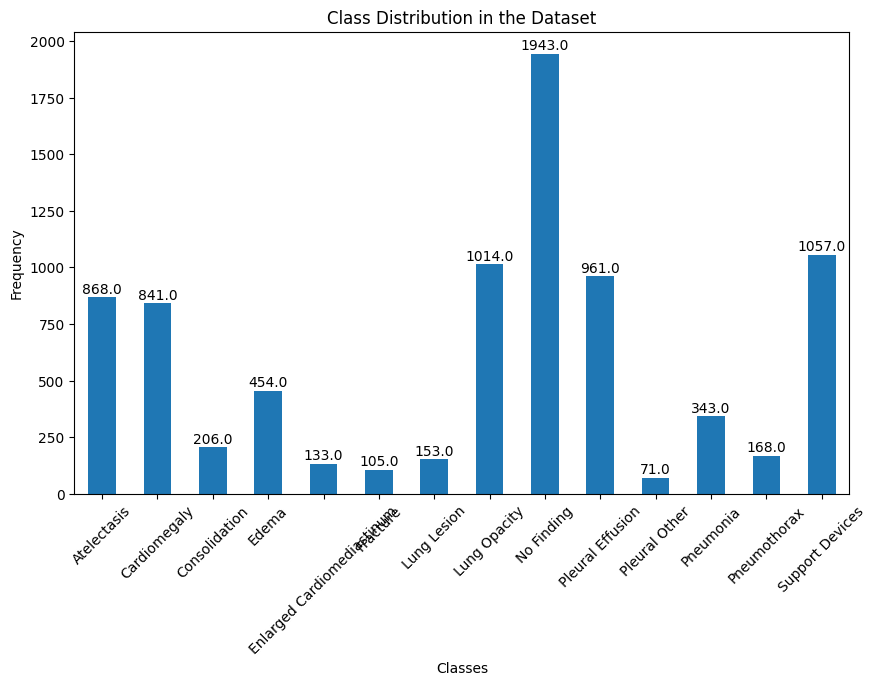

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/content/drive/MyDrive/cleaned_fileforread5000.csv')
labels = data[[ "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"]].to_numpy()
target_columns = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity","No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax","Support Devices"
]
data[target_columns] = data[target_columns].fillna(0)
data[target_columns] = data[target_columns].applymap(lambda x: 0 if x < 0 else x)

# Calculate class frequencies
class_frequencies = data[target_columns].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = class_frequencies.plot(kind='bar')
plt.title('Class Distribution in the Dataset')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Display the count values on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom')

plt.show()
